# Airbnb Data Analysis

Data from [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

Command to convert the ipynb to rmkdwn : ```rmarkdown:::convert_ipynb('Airbnb Data Analysis.ipynb')```


## Data Preparation
1. Prepare data set for each city
2. Clean data for each city

In [1]:
# Need to install this package first
# install.packages("stringi")

In [2]:
library(dplyr)
# issue with this one
library(stringr)
library(ggplot2)
library(data.table)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Warning message:
"package 'data.table' was built under R version 4.0.3"

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last




In [3]:
# Function from the data_prep script

# a generic function to prepare data for a specific city, data_date
prepare_data <- function(city, data_date)
{
    # Cleaning listings dataframe
    
    # suppose raw data is stored in data_raw/city/data_date/listings.csv.gz
    listings_url <- file.path("data_raw", city, data_date, "listings.csv.gz")
    # suppose raw data is stored in data_raw/city/data_date/calendar.csv.gz
    calendar_url <- file.path("data_raw", city, data_date, "calendar.csv.gz")
    
    print(paste0("reading data from ", listings_url))
    listings <- read.csv(gzfile(listings_url))
    print(paste0("reading data from ", calendar_url))
    calendar <- read.csv(gzfile(calendar_url))
    
    ## Add Keys: columns city and day date
    listings$city <- city
    listings$data_date <- data_date
    
    ## Select interesting columns
    ### Most columns don't contain interesting information
    columns_listings <- c("city", "data_date", "id", "neighbourhood_cleansed", 
                          "latitude", "longitude", 
                          "property_type", "room_type", "accommodates", "bedrooms", 
                          "beds", "price", "minimum_nights",  "maximum_nights")
    
    listings <- listings %>% 
        select(columns_listings) %>% 
        arrange(id)
    
    
    # Cleaning calendar dataframe
    
    ## arrange by id and date
    calendar <- calendar %>% 
        arrange(listing_id, date)
    
    ## add day number (starting first day)
    calendar <- calendar %>%
        group_by(listing_id) %>%
        mutate(day_nb = row_number()) %>%
        ungroup()
    
    ## change available column to binary
    calendar <- calendar %>%
        mutate(available = ifelse(available=="t", 1, 0))
    
    ## clean price column and transform to numeric
    calendar <- calendar %>%
        mutate(price = str_replace(price, "\\$", ""),
               adjusted_price = str_replace(adjusted_price, "\\$", ""))
    calendar <- calendar %>%
        mutate(price = str_replace(price, ",", ""),
               adjusted_price = str_replace(adjusted_price, ",", ""))
    calendar <- calendar %>%
        mutate(price = as.numeric(price),
               adjusted_price = as.numeric(adjusted_price))
    
    ## calculate estimated revenue for upcoming day
    calendar <- calendar %>%
        mutate(revenue = price*(1-available))
    
    ## calculate availability, price, revenue for next 30, 60 days ... for each listing_id
    calendar <- calendar %>%
        group_by(listing_id) %>%
        summarise(availability_30 = sum(available[day_nb<=30], na.rm = TRUE),
                  availability_60 = sum(available[day_nb<=60], na.rm = TRUE),
                  availability_90 = sum(available[day_nb<=90], na.rm = TRUE),
                  availability_365 = sum(available[day_nb<=365], na.rm = TRUE),
                  price_30 = mean(price[day_nb<=30 & available==0], na.rm = TRUE),
                  price_60 = mean(price[day_nb<=60 & available==0], na.rm = TRUE),
                  price_90 = mean(price[day_nb<=90 & available==0], na.rm = TRUE),
                  price_365 = mean(price[day_nb<=365 & available==0], na.rm = TRUE),
                  revenue_30 = sum(revenue[day_nb<=30], na.rm = TRUE),
                  revenue_60 = sum(revenue[day_nb<=60], na.rm = TRUE),
                  revenue_90 = sum(revenue[day_nb<=90], na.rm = TRUE),
                  revenue_365 = sum(revenue[day_nb<=365], na.rm = TRUE)           
        )
    
    listings_cleansed <- listings %>% left_join(calendar, by = c("id" = "listing_id"))
    
    dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE)
    
    write.csv(listings_cleansed, file.path("data_cleansed", city, data_date, "listings.csv"))
    print(paste0("saving data into ", file.path("data_cleansed", city, data_date, "listings.csv")))
    
}  

### Unit test : Reading data for malaga:
#### Preparing data, working ✅

In [4]:
# city <- "malaga"
# data_date <- "2020-06-30"
# prepare_data(city,data_date)

# Prepare data for all selected cities 

In [5]:
# Reading cleansed data
cities <- c("malaga", "mallorca", "sevilla")
data_dates <- c("2020-06-30", "2020-09-19", "2020-06-29")

# We are only interested in data between min_date and max_date
min_date <- '2020-05-01'
max_date <- '2020-11-01'

files_paths <- c()

### Preparare data for Malaga, mallorca, sevilla

In [6]:
for(i in 1:length(cities)){
    city <- cities[i]
    data_date <- data_dates[i]
    print("-------------------------------------------------")
    print(paste(c("Preparing data for", city, "compiled at", data_date), collapse = " "))
    prepare_data(city, data_date)
}

# Clean Environment
rm(list=ls())

[1] "-------------------------------------------------"
[1] "Preparing data for malaga compiled at 2020-06-30"
[1] "reading data from data_raw/malaga/2020-06-30/listings.csv.gz"
[1] "reading data from data_raw/malaga/2020-06-30/calendar.csv.gz"


Note: Using an external vector in selections is ambiguous.
i Use `all_of(columns_listings)` instead of `columns_listings` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

`summarise()` ungrouping output (override with `.groups` argument)

Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
"'data_cleansed\malaga\2020-06-30' existe déjà"


[1] "saving data into data_cleansed/malaga/2020-06-30/listings.csv"
[1] "-------------------------------------------------"
[1] "Preparing data for mallorca compiled at 2020-09-19"
[1] "reading data from data_raw/mallorca/2020-09-19/listings.csv.gz"
[1] "reading data from data_raw/mallorca/2020-09-19/calendar.csv.gz"


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
"'data_cleansed\mallorca\2020-09-19' existe déjà"


[1] "saving data into data_cleansed/mallorca/2020-09-19/listings.csv"
[1] "-------------------------------------------------"
[1] "Preparing data for sevilla compiled at 2020-06-29"
[1] "reading data from data_raw/sevilla/2020-06-29/listings.csv.gz"
[1] "reading data from data_raw/sevilla/2020-06-29/calendar.csv.gz"


`summarise()` ungrouping output (override with `.groups` argument)

Warning message in dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE):
"'data_cleansed\sevilla\2020-06-29' existe déjà"


[1] "saving data into data_cleansed/sevilla/2020-06-29/listings.csv"


In [7]:
# Reading cleansed data
cities <- c("malaga", "mallorca", "sevilla")
data_dates <- c("2020-06-30", "2020-09-19", "2020-06-29")

# We are only interested in data between min_date and max_date
min_date <- '2020-05-01'
max_date <- '2020-11-01'

files_paths <- c()

### Read data in cities between min_date and max_date

In [8]:
for(city in cities){
    file_dir <- file.path(".", "data_cleansed", city)
    file_subdirs <- list.dirs(file_dir)
    file_subdirs <- file_subdirs[-1]

    for(file_subdir in file_subdirs){
        if(file_subdir < file.path(file_dir, min_date) | file_subdir > file.path(file_dir, max_date)  )
            file_subdirs = file_subdirs[file_subdirs != file_subdir]
    }
    files_paths <- c(files_paths, file_subdirs)
}
files_paths <- file.path(files_paths, "listings.csv")
listings <- 
    do.call(rbind,
            lapply(files_paths, read.csv, row.names=1))

In [9]:
summary(listings)

     city            data_date               id          
 Length:30577       Length:30577       Min.   :   11547  
 Class :character   Class :character   1st Qu.:17278276  
 Mode  :character   Mode  :character   Median :26547472  
                                       Mean   :26203204  
                                       3rd Qu.:37310559  
                                       Max.   :45499210  
                                                         
 neighbourhood_cleansed    latitude       longitude       property_type     
 Length:30577           Min.   :36.64   Min.   :-6.0165   Length:30577      
 Class :character       1st Qu.:37.39   1st Qu.:-4.4354   Class :character  
 Mode  :character       Median :39.43   Median : 2.6531   Mode  :character  
                        Mean   :38.56   Mean   :-0.4932                     
                        3rd Qu.:39.71   3rd Qu.: 3.0743                     
                        Max.   :39.93   Max.   : 3.4755                   

### Make a copy of the full dataset

In [10]:
listings_full <- listings[complete.cases(listings), ]

### Preprocessing 

In [11]:
listings$bedrooms <- ifelse(listings$bedrooms >= 5, "5+", listings$bedrooms)

# to do : break even point
# steps 1 : find the average price for the squarre meter in the city --> fixed costs 
# steps 2 : find the average price for the electricity and gas for --> variable costs 
# steps 3 : compute the break even point in day

In [12]:
summary(listings)

     city            data_date               id          
 Length:30577       Length:30577       Min.   :   11547  
 Class :character   Class :character   1st Qu.:17278276  
 Mode  :character   Mode  :character   Median :26547472  
                                       Mean   :26203204  
                                       3rd Qu.:37310559  
                                       Max.   :45499210  
                                                         
 neighbourhood_cleansed    latitude       longitude       property_type     
 Length:30577           Min.   :36.64   Min.   :-6.0165   Length:30577      
 Class :character       1st Qu.:37.39   1st Qu.:-4.4354   Class :character  
 Mode  :character       Median :39.43   Median : 2.6531   Mode  :character  
                        Mean   :38.56   Mean   :-0.4932                     
                        3rd Qu.:39.71   3rd Qu.: 3.0743                     
                        Max.   :39.93   Max.   : 3.4755                   

## Example of analysis

Warning message:
"Removed 3058 rows containing non-finite values (stat_boxplot)."


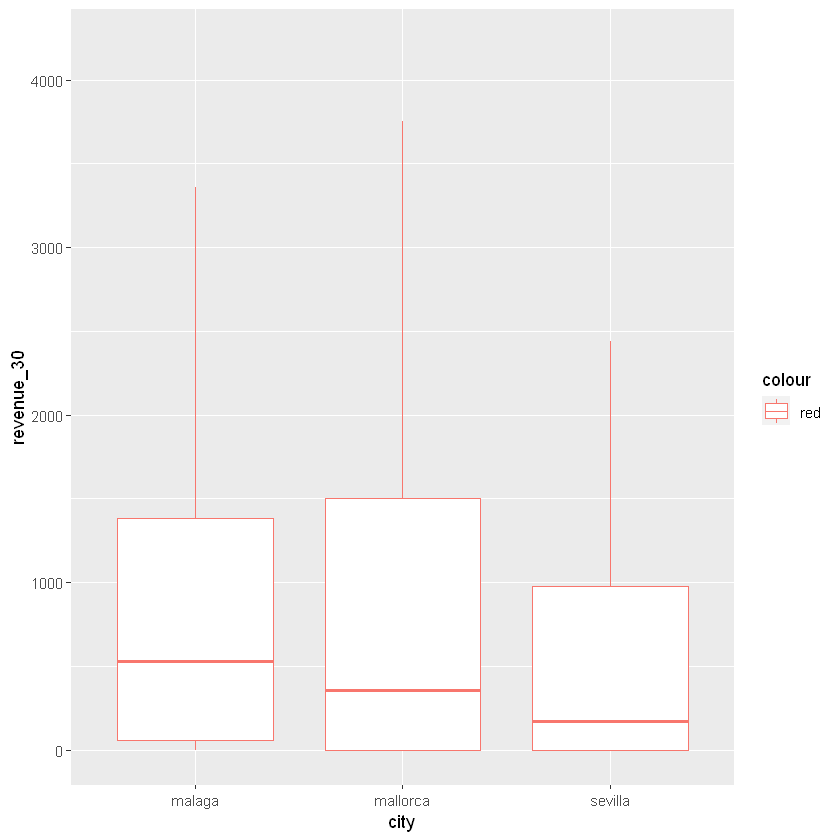

In [13]:
# Analysis 1
## Comparing the distribution of estimated revenue for the next 30 days of listings
## per each city.
p <- ggplot(listings, aes(city, revenue_30))
p + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T))

## Analysis 1 : comparing cities

#### 1. Find the "average availability over 30 days" of listings per each city

In [14]:
avg_av <- aggregate(listings$availability_30, list(listings$city),mean)

In [15]:
avg_av

Group.1,x
<chr>,<dbl>
malaga,17.96286
mallorca,20.67787
sevilla,19.89412


#### 2. Find the "average revenue over 30 days" of listings per each city

In [16]:
avg_rev <- aggregate(listings$revenue_30,list(listings$city),mean)

In [17]:
avg_rev

Group.1,x
<chr>,<dbl>
malaga,1165.814
mallorca,2158.894
sevilla,1012.779


#### 3. Compare the distribution of estimated availability for the next 30 days of listings per each city
[source](http://www.sthda.com/french/wiki/ggplot2-courbe-de-distribution-guide-de-demarrage-rapide-logiciel-r-et-visualisation-de-donnees)

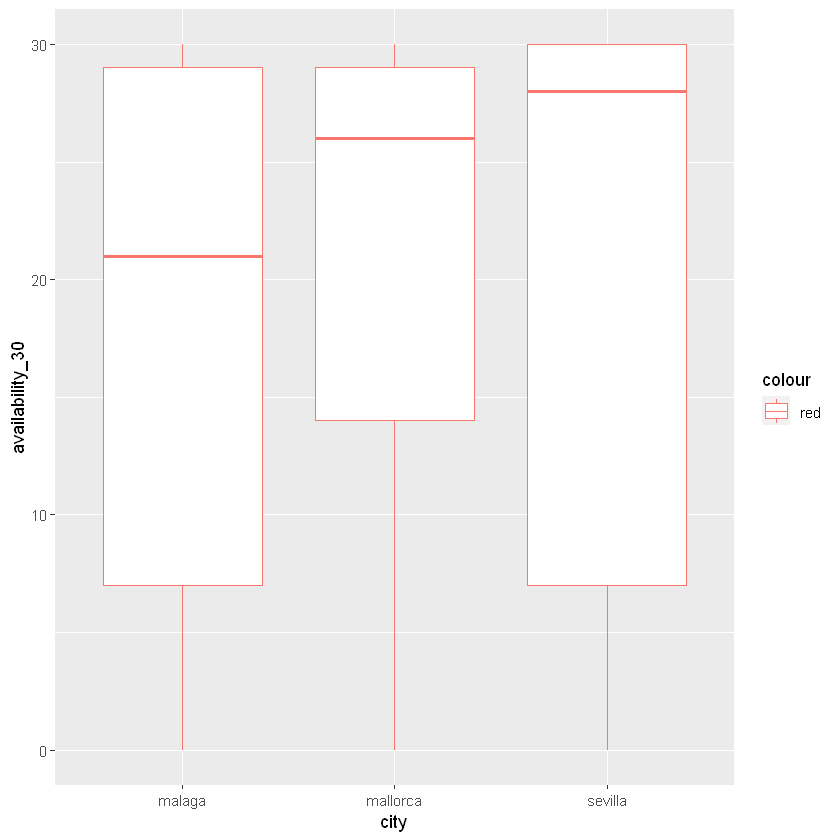

In [18]:
distrib_av <- ggplot(listings, aes(city, availability_30))
distrib_av + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$availability_30, c(0.1, 0.9), na.rm = T))

#### 4. Compare the distribution of estimated revenue for the next 30 days of listings per each city

Warning message:
"Removed 3058 rows containing non-finite values (stat_boxplot)."


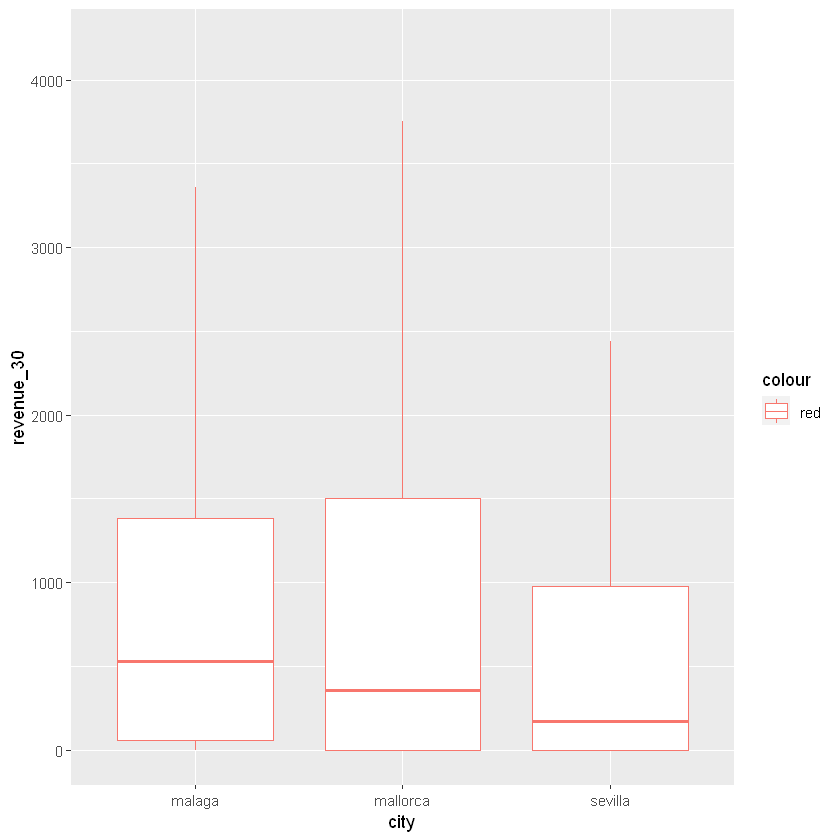

In [19]:
distrib_rv <- ggplot(listings, aes(city, revenue_30))
distrib_rv + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T))

#### 5. Compare the distribution of estimated revenue for the next 30 days of listings per each city & for each house size (# of bedrooms)

Warning message:
"Removed 3028 rows containing non-finite values (stat_boxplot)."


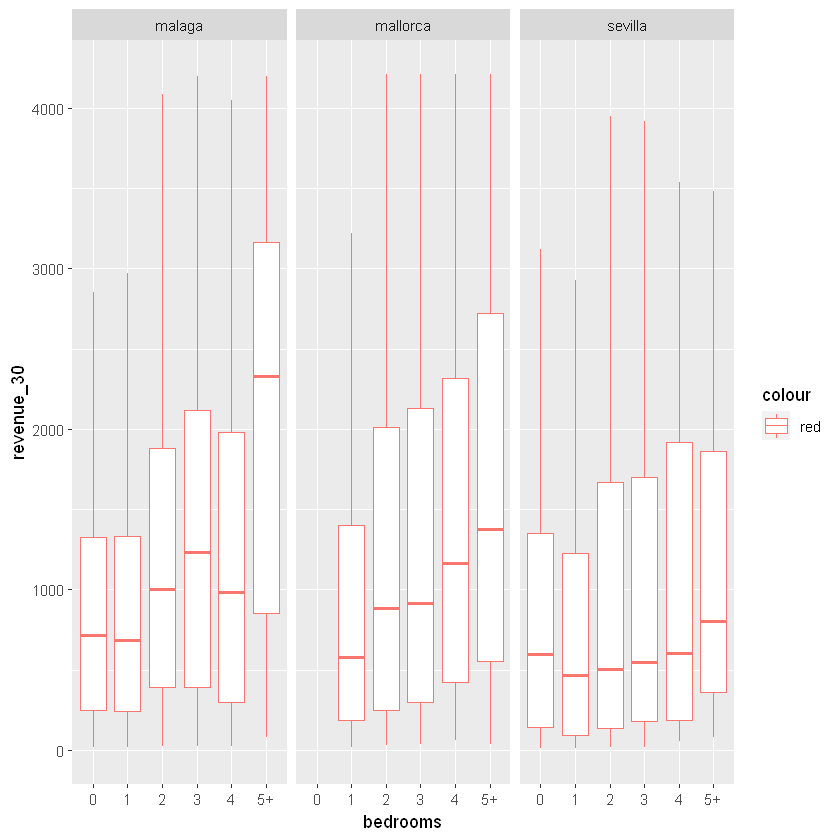

In [20]:
specified <- listings[complete.cases(listings), ]
distrib_rv_hsize <- ggplot(specified, aes(bedrooms, revenue_30))
distrib_rv_hsize + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T)) + 
    facet_wrap(~ city)

#### 6. Compare the distribution of estimated revenue for the next 30 days of listings per each city  & for each room type (room_type)

Warning message:
"Removed 3058 rows containing non-finite values (stat_boxplot)."


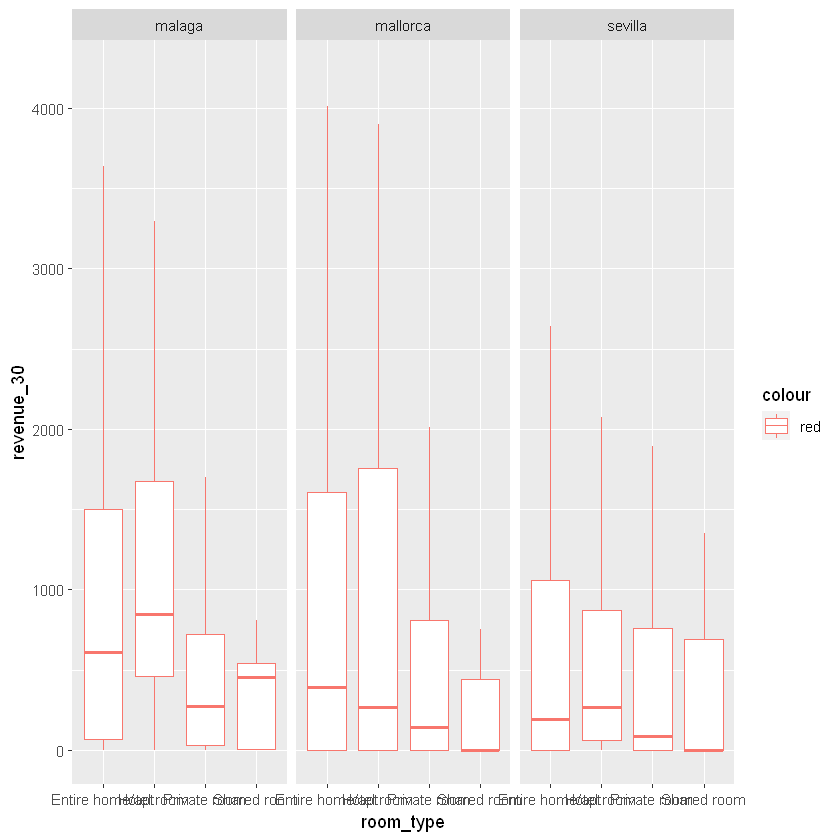

In [21]:
distrib_rv_hsize <- ggplot(listings, aes(room_type, revenue_30))
distrib_rv_hsize + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T)) + 
    facet_wrap(~ city)

## Analysis 2 : Deep Dive in one City Analysis

### Functions

#### Proportion of each room type

In [22]:
aggregated_room_types <- function(selected_city){
      listings %>%
      filter(city == selected_city) %>%
      group_by(room_type) %>%
      summarise(nb_rooms = n()) %>%
      mutate(freq = nb_rooms / sum(nb_rooms))
}

#### Proportion of each house size (# of bedroom)

In [23]:
aggregated_house_size <- function(selected_city){ 
    proportion <- listings %>%
    filter(city == selected_city) %>%
    group_by(bedrooms) %>%
    summarise(houze_size = n()) %>%
    mutate(freq = houze_size / sum(houze_size))
    
    # Removing NA
    proportion[complete.cases(proportion), ]
}

#### Proportion of each neighborhood

In [24]:
aggregated_neighborhood <- function(selected_city){ 
    proportion <- listings %>%
    filter(city == selected_city) %>%
    group_by(neighbourhood_cleansed) %>%
    summarise(ngbh = n()) %>%
    mutate(freq = ngbh / sum(ngbh))
    
    # Removing NA
    proportion[complete.cases(proportion), ]
}


####  Average availability over the next 30 days for each room type / house size / neighborhood

In [25]:
aggregated_availability <- function(selected_city){ 
    avg_availability <- listings %>%
    filter(city == selected_city) %>%
    group_by(room_type,bedrooms,neighbourhood_cleansed) %>%
    summarise(mean_availability_30 = mean(availability_30))

    # Removing NA
    avg_availability[complete.cases(avg_availability), ]
}

#### Average revenue over the next 30 days for each room type / house size / neighborhood

In [26]:
aggregated_revenue <- function(selected_city){ 
    avg_revenue <- listings %>%
    filter(city == selected_city) %>%
    group_by(room_type,bedrooms,neighbourhood_cleansed) %>%
    summarise(mean_revenue_30 = mean(revenue_30))

    # Removing NA
    avg_revenue[complete.cases(avg_revenue), ]
}

####  Distribution of availability over the next 30 days for each room type / house size / neighborhood

In [27]:
availability_plotting <- function(selected_city){
    specified <- listings[complete.cases(listings), ] %>%
      filter(city == selected_city)
    
    q <- ggplot(specified, aes(bedrooms, availability_30))
    q+stat_summary(fun.y="mean", geom="point")+facet_grid(room_type~neighbourhood_cleansed)
}

####  Distribution of revenue over the next 30 days for each room type / house size / neighborhood

In [28]:
revenue_plotting <- function(selected_city){
    specified <- listings[complete.cases(listings), ] %>%
      filter(city == selected_city)
    
    q <- ggplot(specified, aes(bedrooms, revenue_30))
    q+stat_summary(fun.y="mean", geom="point")+facet_grid(room_type~neighbourhood_cleansed)
}

### A. Malaga

In [29]:
selected_city <- 'malaga'
selected_city

[1] "malaga"

#### 1. What is the proportion of each room type?

In [30]:
aggregated_room_types(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



room_type,nb_rooms,freq
<chr>,<int>,<dbl>
Entire home/apt,5345,0.848278051
Hotel room,39,0.006189494
Private room,903,0.143310586
Shared room,14,0.002221870


#### 2. What is the proportion of each house size (# of bedroom)?

In [31]:
aggregated_house_size(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



bedrooms,houze_size,freq
<chr>,<int>,<dbl>
0,512,0.08125694
1,2905,0.46103793
2,1596,0.25329313
3,892,0.14156483
4,262,0.04158070
5+,127,0.02015553


#### 3. What is the proportion of each neighborhood?

In [32]:
aggregated_neighborhood(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



neighbourhood_cleansed,ngbh,freq
<chr>,<int>,<dbl>
Bailen-Miraflores,165,0.026186320
Campanillas,18,0.002856689
Carretera de Cadiz,539,0.085541977
Centro,4327,0.686716394
Churriana,99,0.015711792
Ciudad Jardin,50,0.007935248
Cruz De Humilladero,287,0.045548326
Este,643,0.102047294
Palma-Palmilla,41,0.006506904


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [33]:
aggregated_availability(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,0,Bailen-Miraflores,19.00000
Entire home/apt,0,Campanillas,29.00000
Entire home/apt,0,Carretera de Cadiz,21.31579
Entire home/apt,0,Centro,18.86797
Entire home/apt,0,Churriana,20.12500
Entire home/apt,0,Ciudad Jardin,15.00000
Entire home/apt,0,Cruz De Humilladero,19.00000
Entire home/apt,0,Este,14.06522
Entire home/apt,0,Palma-Palmilla,17.00000


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [34]:
aggregated_revenue(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,0,Bailen-Miraflores,468.0000
Entire home/apt,0,Campanillas,50.0000
Entire home/apt,0,Carretera de Cadiz,720.0526
Entire home/apt,0,Centro,826.8875
Entire home/apt,0,Churriana,811.6250
Entire home/apt,0,Ciudad Jardin,1210.0000
Entire home/apt,0,Cruz De Humilladero,466.8000
Entire home/apt,0,Este,1003.6957
Entire home/apt,0,Palma-Palmilla,616.0000


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


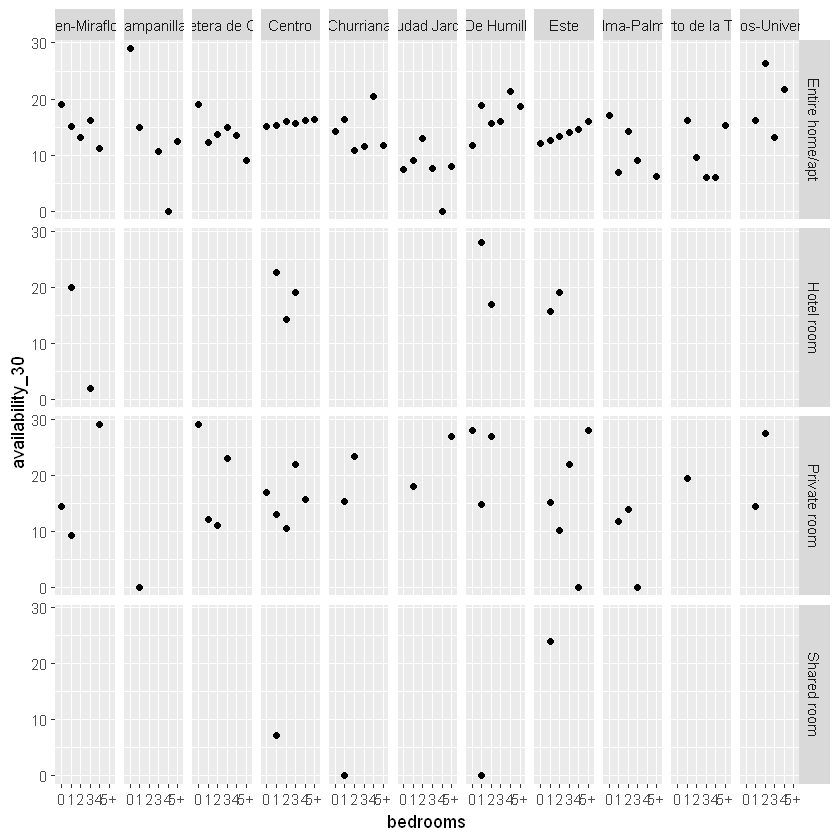

In [35]:
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


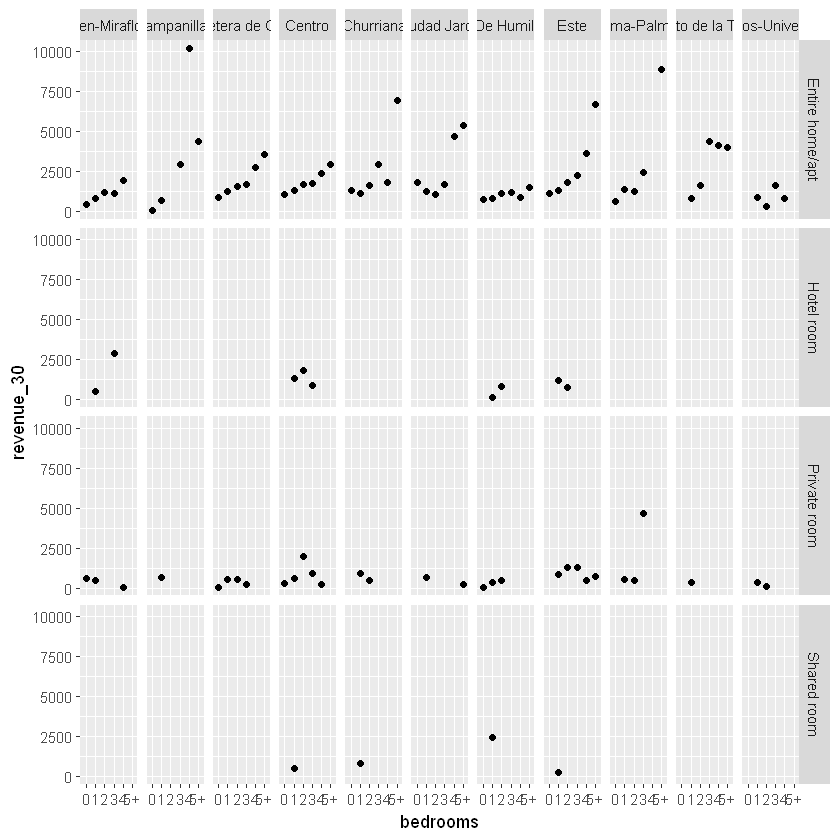

In [36]:
revenue_plotting(selected_city)

### B. Mallorca

In [37]:
selected_city <- 'mallorca'
selected_city

[1] "mallorca"

#### 1. What is the proportion of each room type?

In [38]:
aggregated_room_types(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



room_type,nb_rooms,freq
<chr>,<int>,<dbl>
Entire home/apt,15770,0.895615629
Hotel room,230,0.013062244
Private room,1589,0.090243071
Shared room,19,0.001079055


#### 2. What is the proportion of each house size (# of bedroom)?

In [39]:
aggregated_house_size(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



bedrooms,houze_size,freq
<chr>,<int>,<dbl>
1,3200,0.1817356
2,3299,0.1873580
3,5368,0.3048614
4,3452,0.1960473
5+,2014,0.1143798


#### 3. What is the proportion of each neighborhood?

In [40]:
aggregated_neighborhood(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



neighbourhood_cleansed,ngbh,freq
<chr>,<int>,<dbl>
AlarÃ³,115,0.006531122
AlcÃºdia,1732,0.098364380
Algaida,126,0.007155838
Andratx,260,0.014766015
Ariany,90,0.005111313
ArtÃ,416,0.023625625
Banyalbufar,53,0.003009995
BÃºger,172,0.009768287
Binissalem,99,0.005622444


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [41]:
aggregated_availability(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,1,AlarÃ³,22.87500
Entire home/apt,1,AlcÃºdia,23.41748
Entire home/apt,1,Algaida,18.90909
Entire home/apt,1,Andratx,21.27273
Entire home/apt,1,ArtÃ,21.05882
Entire home/apt,1,Banyalbufar,20.20000
Entire home/apt,1,BÃºger,7.00000
Entire home/apt,1,Binissalem,17.00000
Entire home/apt,1,Bunyola,19.57143


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [42]:
aggregated_revenue(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,1,AlarÃ³,1822.2500
Entire home/apt,1,AlcÃºdia,575.1942
Entire home/apt,1,Algaida,1552.0000
Entire home/apt,1,Andratx,979.0909
Entire home/apt,1,ArtÃ,908.0000
Entire home/apt,1,Banyalbufar,1047.0000
Entire home/apt,1,BÃºger,2102.5000
Entire home/apt,1,Binissalem,1727.5000
Entire home/apt,1,Bunyola,616.8571


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


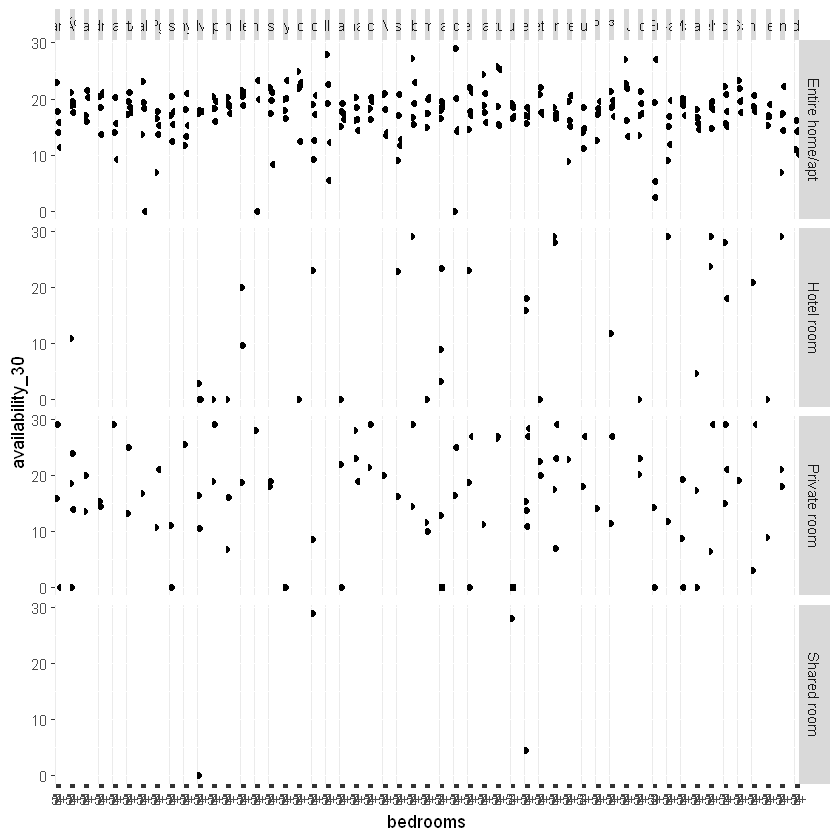

In [43]:
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


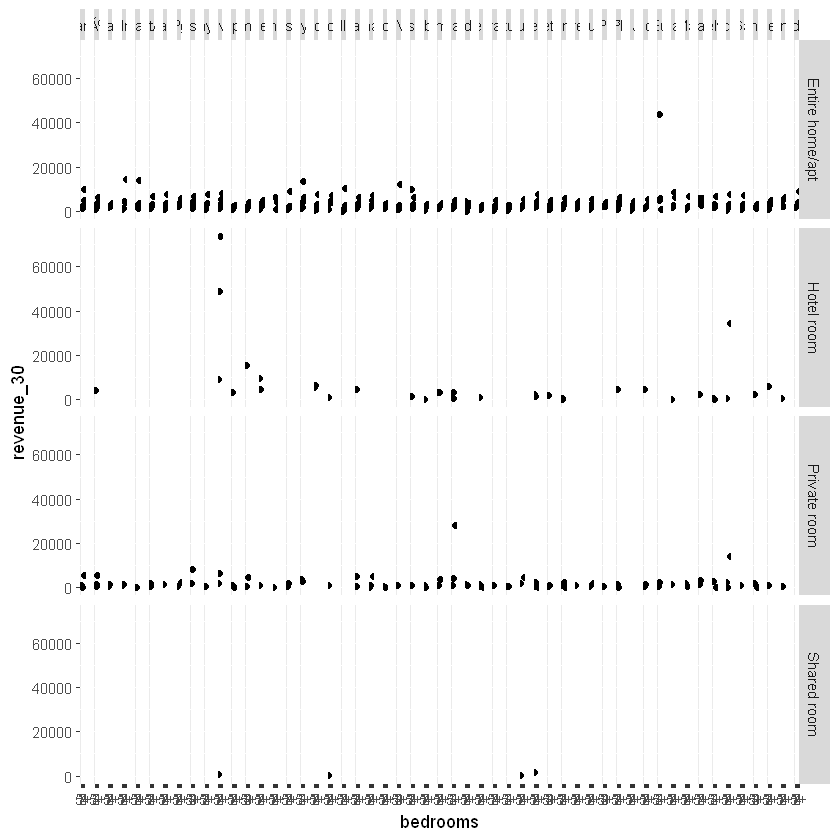

In [44]:
revenue_plotting(selected_city)

### C. Sevilla

In [45]:
selected_city <- 'sevilla'
selected_city

[1] "sevilla"

#### 1. What is the proportion of each room type?

In [46]:
aggregated_room_types(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



room_type,nb_rooms,freq
<chr>,<int>,<dbl>
Entire home/apt,5250,0.78734253
Hotel room,114,0.01709658
Private room,1286,0.19286143
Shared room,18,0.00269946


#### 2. What is the proportion of each house size (# of bedroom)?

In [47]:
aggregated_house_size(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



bedrooms,houze_size,freq
<chr>,<int>,<dbl>
0,329,0.04934013
1,3519,0.52774445
2,1874,0.28104379
3,690,0.10347930
4,169,0.02534493
5+,85,0.01274745


#### 3. What is the proportion of each neighborhood?

In [48]:
aggregated_neighborhood(selected_city)

`summarise()` ungrouping output (override with `.groups` argument)



neighbourhood_cleansed,ngbh,freq
<chr>,<int>,<dbl>
Aeropuerto Viejo,1,0.00014997
Alfalfa,745,0.11172765
Amate,5,0.00074985
an Roque,66,0.00989802
Arbol Gordo,2,0.00029994
Arenal,492,0.07378524
Avda. de la Paz,5,0.00074985
Bami,6,0.00089982
Barrio LeÃ³n,21,0.00314937


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [49]:
aggregated_availability(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,0,Alfalfa,21.59574
Entire home/apt,0,an Roque,14.50000
Entire home/apt,0,Arenal,22.26471
Entire home/apt,0,Barrio LeÃ³n,29.00000
Entire home/apt,0,"Carretera de Carmona, MarÃ­a Auxiliadora, Fontanal",17.00000
Entire home/apt,0,Ciudad JardÃ­n,30.00000
Entire home/apt,0,"Doctor Barraquer, G. Renfe, PoliclÃ­nico",30.00000
Entire home/apt,0,"EncarnaciÃ³n, Regina",19.00000
Entire home/apt,0,Feria,16.13793


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [50]:
aggregated_revenue(selected_city)

`summarise()` regrouping output by 'room_type', 'bedrooms' (override with `.groups` argument)



room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<chr>,<chr>,<chr>,<dbl>
Entire home/apt,0,Alfalfa,489.9574
Entire home/apt,0,an Roque,677.5000
Entire home/apt,0,Arenal,617.7941
Entire home/apt,0,Barrio LeÃ³n,31.0000
Entire home/apt,0,"Carretera de Carmona, MarÃ­a Auxiliadora, Fontanal",1388.0000
Entire home/apt,0,Ciudad JardÃ­n,0.0000
Entire home/apt,0,"Doctor Barraquer, G. Renfe, PoliclÃ­nico",0.0000
Entire home/apt,0,"EncarnaciÃ³n, Regina",555.2727
Entire home/apt,0,Feria,1837.1034


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


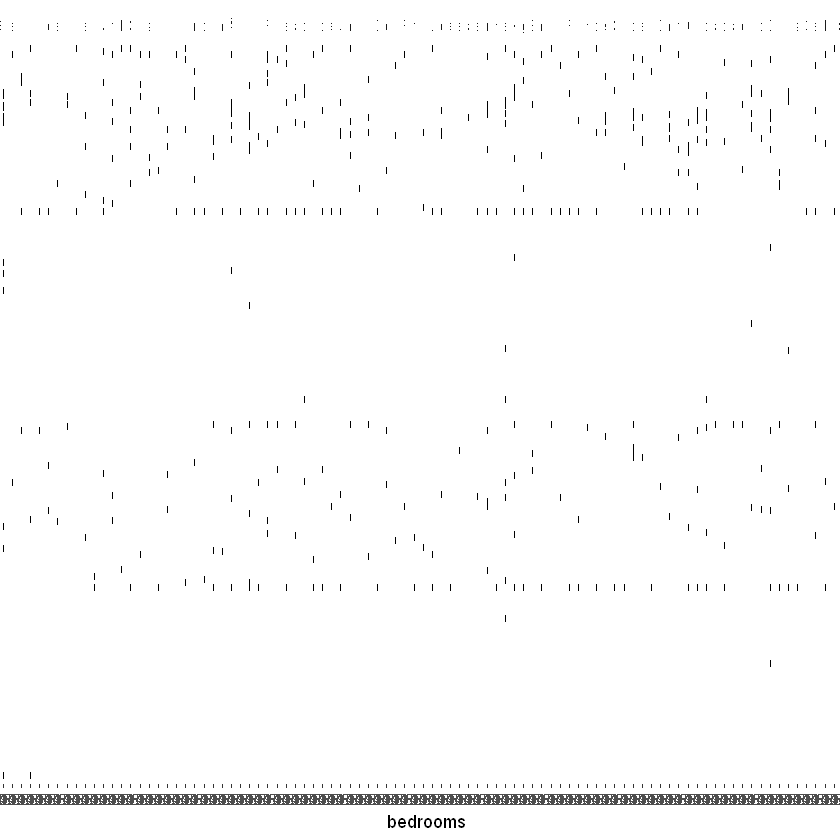

In [51]:
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

Warning message:
"`fun.y` is deprecated. Use `fun` instead."


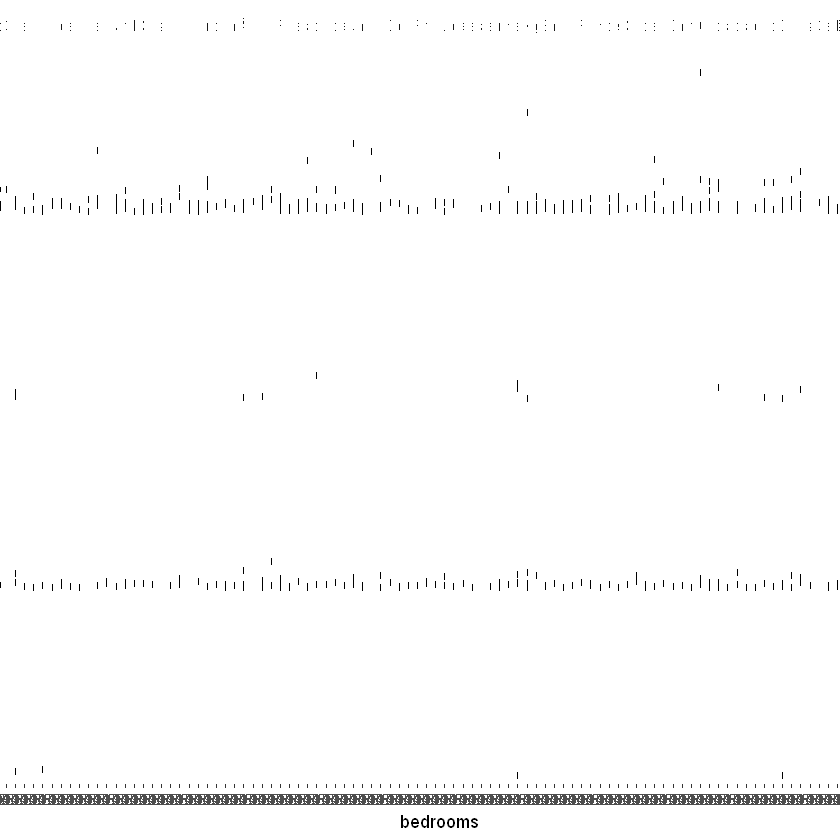

In [52]:
revenue_plotting(selected_city)

## Additional Analysis :
### Compute the break even point 

_Break Event Point_ : the point at which a business starts to make as much money as it has spent on a particular product, activity, etc
The BEP monitors how fast or how much money is required for the invest to make benefits : it is **widely used by managers to interpret the profitability of a product**, in our case : the profitability of the invest.

#### Calculation
$$Break Even Point = {\sum{Fixed Cost} \over Income – VariableCostsPerUnit}.$$

* Fixed costs are costs that are not related to the activity
* Variable costs are costs related to the activity
* Income is the money earned


#### Additionnal Data :
In this particular case : 
* Fixed costs : Price of the Rent
* Variable costs : Electricity
* Income : Revenue over 365 days
Data extracted by this [website](https://www.combien-coute.net/)


|Ville| Sevilla  | Malaga | Majorqua  | 
|--|--|--|--|
|Square Meter| **2516.67 €** | **2842.86 €** | **3483.33 €** |
|Variable Expenses| **126.44 €** | **112.01 €** | **107.92 €**|

#### Consideration : 
For the ease of the data harvesting we consider that:
* the square meter price is even in each city
* the average size for a bedroom is 10 square meter
* each house as a lounge room of a size : ```1,5*number of room+7,5```
* the price of the electricity is the same for every house

### Bonus :
For each city :
- [ ] Fetch the price of squaremeter in each city : fixed cost
- [ ] Fetch the price of the electricity and water in each city : variable cost 
- [ ] Compute the breakeven point in days and in € : Fixed Cost / (Income-variable cost)

### For the 3 cities

In [53]:
cities <- c("sevilla","malaga", "mallorca")
square_meter <- c(2516.67,2842.86,3483.33)
charges <- c(126.44,112.01,107.92)

In [54]:
for(i in 1:length(cities)){
    city <- cities[i]
    bool_index <- listings_full$city==city
    # Creating fixed costs column 
    fixed_cost<-(square_meter[i]*(listings_full[bool_index,]$bedrooms* 10 + (1.5*listings_full[bool_index,]$bedrooms+8.5)))
    listings_full[bool_index, 'fixed_cost'] <- fixed_cost
    # Creating var costs column
    listings_full[bool_index, 'var_cost'] <- ((charges[i]/31) * (365-as.integer(listings_full[bool_index, ]$availability_365)))
    # Break Even Point in Year
    listings_full[bool_index,'bep_year'] <- listings_full[bool_index,]$fixed_cost/(listings_full[bool_index,]$revenue_365-listings_full[bool_index,]$var_cost)
    # Break Even Point in Turnover
    listings_full[bool_index,'bep_turnover'] <- listings_full[bool_index,]$fixed_cost/((listings_full[bool_index,]$revenue_365-listings_full[bool_index,]$var_cost)/listings_full[bool_index,]$revenue_365)
}

In [55]:
avg_bep_year <- aggregate(listings_full$bep_year,list(listings_full$city),mean)
avg_bep_year

Group.1,x
<chr>,<dbl>
malaga,61.64183
mallorca,84.00211
sevilla,81.32288


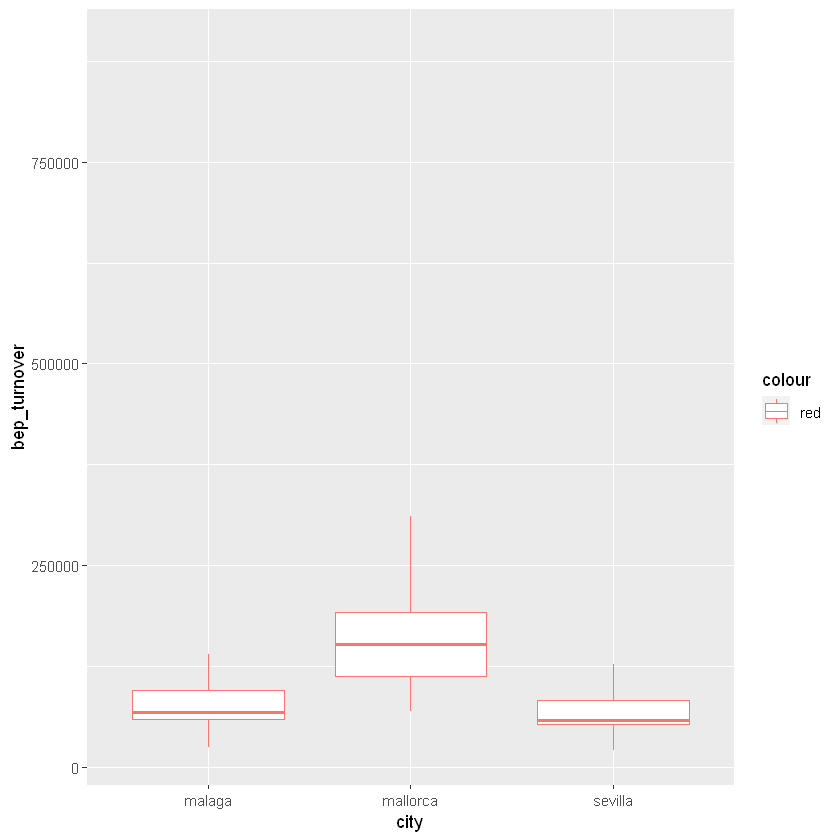

In [56]:
distrib_bep_year <- ggplot(listings_full, aes(city, bep_turnover))
distrib_bep_year + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$bep_turnover, c(0.1, 0.9), na.rm = T))

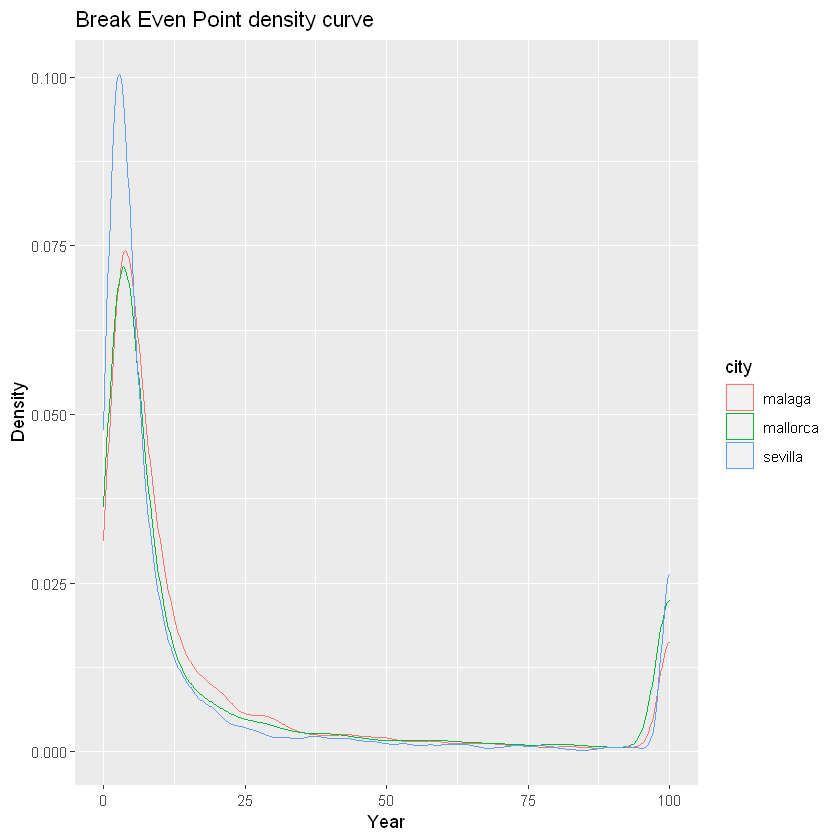

In [57]:
# To smooth the Break Even Point in Year
listings_full$bep_year[listings_full$bep_year>100] <- 100
p<- ggplot(listings_full, aes(x=bep_year, color=city)) +
  geom_density(size=0.5)+
  labs(title="Break Even Point density curve",x="Year", y = "Density")
p

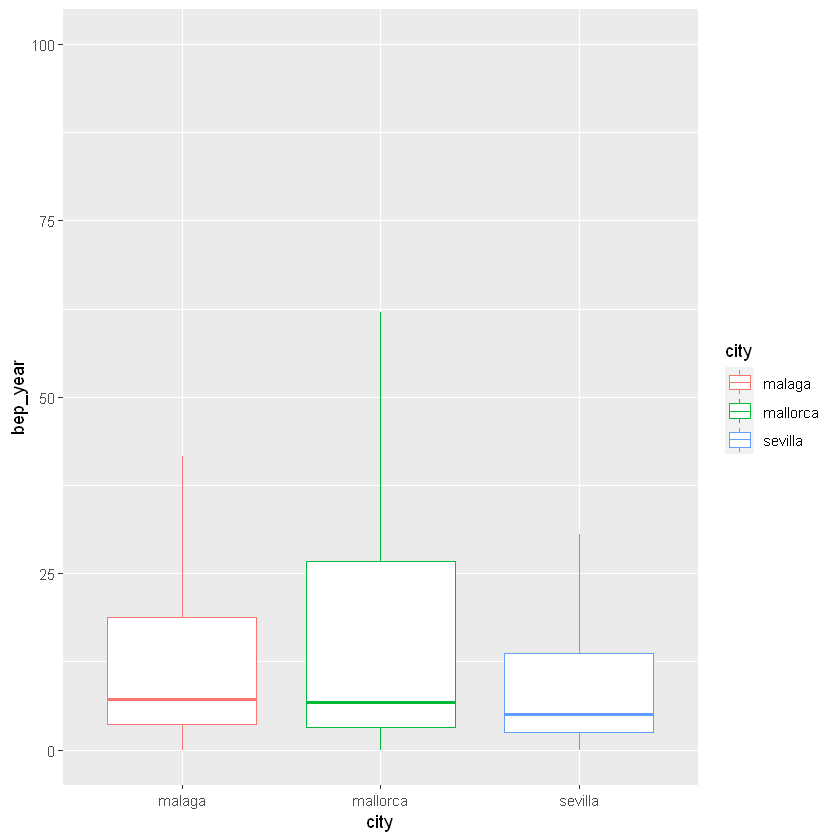

In [58]:
distrib_bep_year <- ggplot(listings_full, aes(city, bep_year))
distrib_bep_year + geom_boxplot(aes(colour = city), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$bep_turnover, c(0.1, 0.9), na.rm = T))